# Particle Swarm Optimisation for Graph Neural Network Architecture Search

In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

This GNN can handle different types of convolutional layers, and both node and graph classification.
The build_conv_model method determines which type of convolutional layer to use for the given task, a graph convolutional network for node classificationtion (GCNConv) and a graph isomorphism network for graph classification (GINConv).
This model is made of 3 covolution layers followed by mean pooling in the case of graph classification, followed by 2 fully connected layers.
Sing our goal here is classification, we use a negative log-likelihood loss function.

List of the changeable hyperparameters:

    - hidden_dim (dimmension of hidden layers)

    - number of convs layers

    - number of lns layers (normalisation layers)
    

In [108]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node', hidden_num = 2):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList() #convolution operations
        self.lns = nn.ModuleList() #normalisation operations
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        # adding convolution an normalisation layers
        for l in range(hidden_num):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))
            self.lns.append(nn.LayerNorm(hidden_dim))

        # self.lns.append(nn.LayerNorm(hidden_dim))


        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim)) # adding 2 linear layers 
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        # create different types of GCNConv according to the problem to solve
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        # x = feature matrix = number of nodes * number of node feature dimensions,
        # edge_index = list of the edges in the graph,
        # batch = batch of a graph
        x, edge_index, batch = data.x, data.edge_index, data.batch

        if data.num_node_features == 0: #if there is no feature, use a constant feature
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers): # ,create num_layers convolution layers
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.task == 'graph': # if it is a graph classification task, do a pooling
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

pyg_nn.GCNConv and pyg_nn.GINConv are instances of MessagePassing, They define a single layer of graph convolution, which can be decomposed into:
- Message computation
- Aggregation
- Update
- Pooling

With CustomConv, we have an exemple of how to subclass the pytorch geometric MessagePassing class to derive a new model  rather than using existing GCNConv and GINConv.
We use the MessagePassing's key building blocks:
- aggr='add': The aggregation method to use ("add", "mean" or "max").
- propagate(): The initial call to start propagating messages. Takes in the edge indices and any other data to pass along (e.g. to update node embeddings).
- message(): Constructs messages to node i. Takes any argument which was initially passed to propagate().
- update(): Updates node embeddings. Takes in the output of aggregation as first argument and any argument which was initially passed to propagate().

In [109]:
class CustomConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(aggr='add')  # "Add" aggr egation.
        self.lin = nn.Linear(in_channels, out_channels)
        self.lin_self = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Add self-loops to the adjacency matrix.
        edge_index, _ = pyg_utils.remove_self_loops(edge_index)

        # Transform node feature matrix.
        self_x = self.lin_self(x)
        #x = self.lin(x)

        # start the propagation of the message
        return self_x + self.propagate(edge_index, size=(x.size(0), x.size(0)), x=self.lin(x))

    def message(self, x_i, x_j, edge_index, size):
        # Compute messages
        # x_j has shape [E, out_channels]

        row, col = edge_index
        deg = pyg_utils.degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        return aggr_out

Training the model with forward propagation and back propagation. 
For node classification, we split nodes into training and testing sets.
Same thing for graph classification, we use 80% of the graphs for training and the remainder for testing.

In [128]:
def train(dataset, task, writer):
    trigger = 0
    prev_acc = 0.0

    if task == 'graph':
        data_size = len(dataset)
        # split data  into traning and testing set
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = DataLoader(dataset, batch_size=64, shuffle=True)
        loader = test_loader

    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)
    
    # train for 200 epochs
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            # print(batch.train_mask, '----')
            opt.zero_grad()

            # get the prediction and the excpeted label
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        # print accuracy
        test_acc = test(test_loader, model)
        print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
            epoch, total_loss, test_acc))
        writer.add_scalar("test accuracy", test_acc, epoch)

        if test_acc <= prev_acc:
            trigger += 1

        if trigger >= 10:
            print("the model is not learning anymore.")
            break
        prev_acc = test_acc

    return model

For the CiteSeer/Cora node classification task, there is only one graph, so we use masking to determine validation and test set. In graph classification, a subset of graphs is considered as a validation/test graph

In [111]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad(): # avoid gradient computing for faster results
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
     
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct / total

In [112]:
# get_ipython().system_raw(
#     'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#     .format("./log")
# )
# get_ipython().system_raw('./ngrok http 6006 &')
# !curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [131]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = dataset.shuffle()
task = 'graph'

model = train(dataset, task, writer)

Epoch 0. Loss: 1.8233. Test accuracy: 0.1417
Epoch 1. Loss: 1.8047. Test accuracy: 0.1500
Epoch 2. Loss: 1.7922. Test accuracy: 0.1500
Epoch 3. Loss: 1.7953. Test accuracy: 0.1250
Epoch 4. Loss: 1.7914. Test accuracy: 0.1250
Epoch 5. Loss: 1.7915. Test accuracy: 0.1083
Epoch 6. Loss: 1.7864. Test accuracy: 0.1833
Epoch 7. Loss: 1.7856. Test accuracy: 0.2083
Epoch 8. Loss: 1.7828. Test accuracy: 0.2333
Epoch 9. Loss: 1.7745. Test accuracy: 0.1500
Epoch 10. Loss: 1.7677. Test accuracy: 0.1833
Epoch 11. Loss: 1.7670. Test accuracy: 0.2083
Epoch 12. Loss: 1.7585. Test accuracy: 0.1583
Epoch 13. Loss: 1.7580. Test accuracy: 0.2500
Epoch 14. Loss: 1.7608. Test accuracy: 0.2333
Epoch 15. Loss: 1.7707. Test accuracy: 0.2000
Epoch 16. Loss: 1.7565. Test accuracy: 0.1917
Epoch 17. Loss: 1.7651. Test accuracy: 0.2250
Epoch 18. Loss: 1.7575. Test accuracy: 0.2167
the model is not learning anymore.


In [124]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid(root='/tmp/cora', name='cora')
task = 'node'

model = train(dataset, task, writer)

Processing...
Done!
/home/tristan/anaconda3/envs/thesis/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0. Loss: 2.0035. Test accuracy: 0.2570
Epoch 1. Loss: 1.8598. Test accuracy: 0.4880
Epoch 2. Loss: 1.7585. Test accuracy: 0.5270
Epoch 3. Loss: 1.6115. Test accuracy: 0.6490
Epoch 4. Loss: 1.4219. Test accuracy: 0.6920
Epoch 5. Loss: 1.2749. Test accuracy: 0.7100
Epoch 6. Loss: 1.0764. Test accuracy: 0.7130
Epoch 7. Loss: 0.8811. Test accuracy: 0.7360
Epoch 8. Loss: 0.6396. Test accuracy: 0.7370
Epoch 9. Loss: 0.5458. Test accuracy: 0.7420
Epoch 10. Loss: 0.4297. Test accuracy: 0.7320
Epoch 11. Loss: 0.3416. Test accuracy: 0.7140
Epoch 12. Loss: 0.2987. Test accuracy: 0.7440
Epoch 13. Loss: 0.2196. Test accuracy: 0.7670
Epoch 14. Loss: 0.1302. Test accuracy: 0.7710
Epoch 15. Loss: 0.1005. Test accuracy: 0.7610
Epoch 16. Loss: 0.1275. Test accuracy: 0.7650
Epoch 17. Loss: 0.1114. Test accuracy: 0.7590
Epoch 18. Loss: 0.1518. Test accuracy: 0.7490
Epoch 19. Loss: 0.0427. Test accuracy: 0.7380
Epoch 20. Loss: 0.0264. Test accuracy: 0.7330
Epoch 21. Loss: 0.0285. Test accuracy: 0.728

/home/tristan/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/tristan/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: 'c' argument has 600 elements, which is inconsistent with 'x' and 'y' with size 19580.

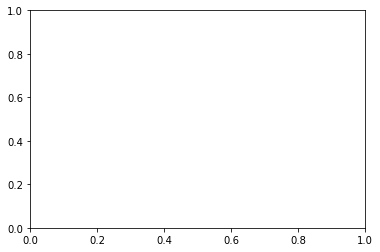

In [132]:
color_list = ["red", "orange", "green", "blue", "purple", "brown", "black"]

loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader:
    emb, pred = model(batch)
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color=colors)